In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import cKDTree
from IPython.display import clear_output

In [2]:
plt.rcParams['font.size'] = 10  # Match 12pt document font size
plt.rcParams['font.weight'] = 400

plt.rcParams['savefig.bbox'] = 'tight' # borderles pdf
plt.rcParams['svg.fonttype'] = 'none'  # selectable text
plt.rcParams['ps.fonttype'] = 42       # selectable text

plt.rcParams['legend.fontsize'] = 10
plt.rcParams['legend.fancybox'] = False
plt.rcParams['legend.framealpha'] = 1
plt.rcParams['legend.edgecolor'] = 'black'

latexFigureWidth = 6.202

Useful function for later: Using the Box-Muller algorithm for generating normally distributed random numbers:

For two random uniformly chosen numbers $U_1$ and $U_2$ (between 0 and 1), then
\begin{align}
  Z_0 &= \sqrt{-2 \log U_1} \cos(2\pi U_2) \quad \text{and} \\
  Z_1 &= \sqrt{-2 \log U_1} \sin(2\pi U_2)
\end{align}
are independent normally distributed random variables following $Z_1, Z_2 \in \mathcal{N}(0, 1)$.

This method is implemented to mimic the behavior of `np.random.normal(mu, scale, size)`

In [3]:
def randn(mu=0.0, scale=1.0, size=1):
  """Generate random numbers following a normal distribution using Box-Muller transform.

  Parameters:
    - mu (float): Mean of the distribution (default: 0.0).
    - scale (float): Standard deviation (default: 1.0).
    - size (int or tuple): Number of samples to generate (default: 1).

  Returns:
    - np.ndarray or float: Normally distributed random numbers.
  """
  if isinstance(size, int):
    size = (size,)

  u1 = np.random.uniform(0, 1, size)
  u2 = np.random.uniform(0, 1, size)

  z0 = np.sqrt(-2.0 * np.log(u1)) * np.cos(2.0 * np.pi * u2)
  return mu + scale * z0

Defining constants in useful units:
- Energy: $\mathrm{eV}$
- mass: atomic mass units (is converted to $\mathrm{eV  (fs/Å)^2}$)
- Distance in $\mathrm{Å}$
- time in ps ($1000\, \mathrm{fs} = 1\, \mathrm{ps}$)

In [4]:
k_B = 8.617333262e-5  # Boltzmann constant in eV/K
mass = 157.25         # mass of Gd in u
u_to_eV = 1.036427e-4 # Conversion factor: 1 u = 1.036427e-4 eV (ps/Å)²

σ = 3.304   # in Angstrom
ϵ = 0.1136  # in eV

## Crystal setup

Setup the 3D crystal with dimensions of $x \times y \times z$ unit cells. The Gd atoms in a unit cell are positioned at
$$
r_1 = (1/4, 5/6, 1/4) \\
r_2 = (1/4, 1/6, 3/4) \\
r_3 = (3/4, 1/3, 1/4) \\
r_4 = (3/4, 2/3, 3/4)
$$
The dimensions of a single unit cell are given by $\left(a, \sqrt{3}a, \sqrt{\frac{3}{8}}a\right)$. The complete lattice is composed of 9x5x5 such unit cells (into a so-called supercell). The nearest neighbors are precomputed. Using the assumptions, that the atoms don't move a lot during the simulation, it is save to assume that this will not change

In [5]:
lattice_parameters = np.array([1, np.sqrt(3), np.sqrt(8/3)]) # lattice parameter in Angstrom

# Basis atom positions (fractional coordinates)
basis_atoms = np.array([
    [1/4, 5/6, 1/4],
    [1/4, 1/6, 3/4],
    [3/4, 1/3, 1/4],
    [3/4, 2/3, 3/4]
])

In [6]:
def setup_Gd_crystal(a=σ, Nx=9, Ny=5, Nz=5):
  [ax, ay, az] = a * lattice_parameters

  lattice_points = []
  for i in range(Nx):
    for j in range(Ny):
      for k in range(Nz):
        translation = np.array([i * ax, j * ay, k * az])

        for atom in basis_atoms:
          lattice_points.append(translation + atom * [ax, ay, az])

  return np.array(lattice_points)

In [7]:
def find_nearest_neighbors(lattice, a=σ, Nx=9, Ny=5, Nz=5, cutoff=10):
  """
  Generates a map between an atom and its nearest neighbors

  Parameters:
    - lattice: Position of the atoms
    - a: lattice parameter (defaults to σ)
    - Nx, Ny, Nz: Supercell dimentsions
    - cutoff: region over which the nearest neighbors are precomputed (Å)

  Returns:
    - map between an atom and the index of the nearest neighbors in the "lattice"
  """
  [ax, ay, az] = a * lattice_parameters

  # Apply periodic boundary conditions by considering shifts of neighboring cells
  translations = np.array([
    [dx, dy, dz] for dx in [-1, 0, 1] for dy in [-1, 0, 1] for dz in [-1, 0, 1]
  ])

  supercell_vectors = np.array([[Nx * ax, 0, 0], [0, Ny * ay, 0], [0, 0, Nz * az]])

  # Expand lattice with periodic images
  expanded_lattice = np.vstack([
    lattice + np.dot(shift, supercell_vectors)
    for shift in translations
  ])

  # use cKDTree as a very fast nearest-neighbor search algorithm. It uses indexing under the hood
  tree = cKDTree(expanded_lattice)
  neighbors_map = {}

  for i, atom in enumerate(lattice):
    neighbors = tree.query_ball_point(atom, cutoff)
    neighbors_map[i] = [n % len(lattice) for n in neighbors if (n%len(lattice)) != i]  # Map back to real indices

  return neighbors_map

In [8]:
lattice = setup_Gd_crystal()
nearest_neighbors = find_nearest_neighbors(lattice, cutoff=10)

#### Visualization
Visualize the lattice. All atoms centered around a selected atom. Nearest neighbors are visualized in blue

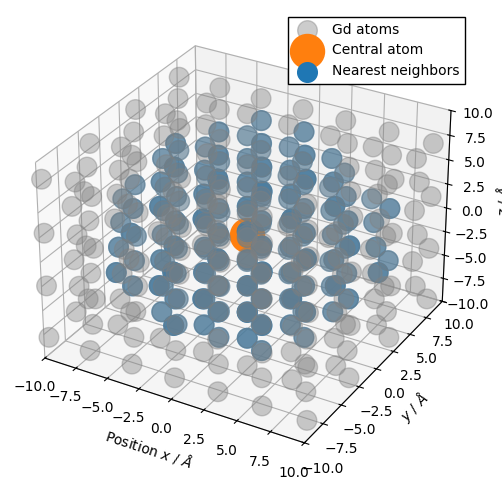

In [9]:
central_atom_idx = 532
box_size = 20

fig = plt.figure(figsize=(6, 6))
fig_ax = fig.add_subplot(111, projection='3d')

central_pos = lattice[central_atom_idx]
mid_x, mid_y, mid_z = central_pos

mask = np.all(
  (lattice > central_pos - box_size/2) &
  (lattice < central_pos + box_size/2),
  axis=1
)

subset_indices = np.where(mask)[0]

fig_ax.scatter(lattice[subset_indices, 0] - mid_x, lattice[subset_indices, 1] - mid_y, lattice[subset_indices, 2] - mid_z, color='gray', alpha=0.4, s=200, label='Gd atoms')
fig_ax.scatter(0, 0, 0, color='C1', s=600, label='Central atom')

#show neighbors
neighbor_indices = nearest_neighbors[central_atom_idx]
neighbor_positions = lattice[neighbor_indices]
visible_neighbors = np.all(
  (neighbor_positions > central_pos - box_size/2) &
  (neighbor_positions < central_pos + box_size/2),
  axis=1
)
visible_neighbor_positions = neighbor_positions[visible_neighbors]

fig_ax.scatter(visible_neighbor_positions[:, 0]-mid_x,
  visible_neighbor_positions[:, 1]-mid_y,
  visible_neighbor_positions[:, 2]-mid_z,
  color='C0', s=200, label="Nearest neighbors")

fig_ax.set_xlabel('Position $x$ / $Å$')
fig_ax.set_ylabel('$y$ / $Å$')
fig_ax.set_zlabel('$z$ / $Å$')

max_range = box_size/2

fig_ax.set_xlim(-max_range, max_range)
fig_ax.set_ylim(-max_range, max_range)
fig_ax.set_zlim(-max_range, max_range)

fig_ax.grid(True)

# for top view
# fig_ax.view_init(elev=90, azim=0)

plt.legend()
plt.show()

## Molecular dynamics simulation


### Simulating the interactions

Defining the **Lennard-Jones potential**
$$
V(\vec{x}) = \sum_{i \neq j}^{N} 4\epsilon \left[ \left(\frac{\sigma}{|\vec{x}_i - \vec{x}_j|}\right)^{12} - \left(\frac{\sigma}{|\vec{x}_i - \vec{x}_j|}\right)^6 \right]
$$
as the potential energy of the lattice

In [10]:
def lennard_jones_potential(r):
  return 4 * ϵ * ((σ/r)**12 - (σ/r)**6)

def lennard_jones_force(r):
  return 24 * ϵ * (2 * (σ/r)**12 - (σ/r)**6) / r

In [11]:
def F(positions, neighbors_map, a=σ, Nx=9, Ny=5, Nz=5):
    """
    Calculate forces on all particles using Lennard-Jones potential with proper periodic boundary conditions (PBC).

    Parameters:
    - positions: Array of shape (num_particles, 3) with positions
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    - Nx, Ny, Nz: Supercell dimensions

    Returns:
    - forces: Array of shape (num_particles, 3) with forces (eV/Å)
    """
    num_particles = len(positions)
    forces = np.zeros((num_particles, 3))

    # Define supercell dimensions
    [ax, ay, az] = a * lattice_parameters
    box_size = np.array([Nx * ax, Ny * ay, Nz * az])
    half_box = box_size / 2

    for i, neighbors in neighbors_map.items():
        pos_i = positions[i]

        for j in neighbors:
            pos_j = positions[j]

            # Calculate distance vector with minimum image convention
            r_ij = pos_i - pos_j

            # Apply minimum image convention for periodic boundary conditions
            for dim in range(3):
                if r_ij[dim] > half_box[dim]:
                    r_ij[dim] -= box_size[dim]
                elif r_ij[dim] < -half_box[dim]:
                    r_ij[dim] += box_size[dim]

            r = np.linalg.norm(r_ij)

            # Skip if atoms are at the same position (should not happen in a crystal)
            if r < 1e-10:
                continue

            force_mag = lennard_jones_force(r)
            force_vec = force_mag * r_ij / r

            forces[i] += force_vec
            # Don't apply Newton's third law here since we're iterating through all pairs

    return forces

def V(positions, neighbors_map, a=σ, Nx=9, Ny=5, Nz=5):
    """
    Calculate the potential energy of all particles using Lennard-Jones potential with proper PBC.

    Parameters:
    - positions: Array of shape (num_particles, 3) with positions
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    - Nx, Ny, Nz: Supercell dimensions

    Returns:
    - total_energy: Total potential energy (eV)
    """
    total_energy = 0
    [ax, ay, az] = a * lattice_parameters
    box_size = np.array([Nx * ax, Ny * ay, Nz * az])
    half_box = box_size / 2

    for atom_idx, neighbor_indices in neighbors_map.items():
        atom_pos = positions[atom_idx]
        atom_energy = 0

        for neighbor_idx in neighbor_indices:
            neighbor_pos = positions[neighbor_idx]

            # Calculate distance vector with minimum image convention
            r_vec = atom_pos - neighbor_pos

            # Apply minimum image convention for periodic boundary conditions
            for dim in range(3):
                if r_vec[dim] > half_box[dim]:
                    r_vec[dim] -= box_size[dim]
                elif r_vec[dim] < -half_box[dim]:
                    r_vec[dim] += box_size[dim]

            r = np.linalg.norm(r_vec)

            # Skip if atoms are at the same position (should not happen in a crystal)
            if r < 1e-10:
                continue

            pair_energy = lennard_jones_potential(r)
            atom_energy += pair_energy

        # Each pair is counted twice in the loop, so divide by 2
        atom_energy /= 2
        total_energy += atom_energy

    return total_energy

### Initial atom velocity

Setup the initial velocity of the lattice atoms. This is given (or assumed) by the **Maxwell-Boltzmann distribution**
$$
p(v_i) = \sqrt{\frac{m_i}{2 \pi k_B T}} e^{-\frac{m_i v_i^2}{2 k_B T}}
$$
The mass of Gd atoms $m_i = 157.25 \,\mathrm{u}$ and $k_B = 8.617333262 \times 10^{-5}\,\mathrm{eV/K}$. This is just a normal distribution around $\langle v_i \rangle=0$ and $\Delta v_i = \frac{k_B T}{m_i}$

In [12]:
def kinetic_energy(velocities):
  speed_sq = np.sum(velocities**2, axis=1)

  return 1/2 * (mass * u_to_eV) * np.sum(speed_sq)

def temperature(velocities):
  E_kin = kinetic_energy(velocities)
  return E_kin / (3/2 * len(velocities) * k_B)

In [13]:
def maxwell_boltzmann(N, T=300):
  velocities = np.zeros((N, 3))

  scale = np.sqrt(k_B * T / (mass * u_to_eV))

  for i in range(3):
    # using the custom Box-Muller algorithm for normal distributed random numbers
    velocities[:, i] = randn(0, scale, N)

  # Remove any net momentum (center of mass motion) and rescale velocities accordingly
  # E_kin_before = kinetic_energy(velocities)

  total_momentum = np.sum(velocities, axis=0)
  velocities -= total_momentum / N

  # scaling_factor = np.sqrt(E_kin_before / kinetic_energy(velocities))
  # velocities *= scaling_factor

  scaling_factor = np.sqrt(T / temperature(velocities))
  velocities *= scaling_factor

  return velocities


In [14]:
initial_velocities = maxwell_boltzmann(len(lattice), T=300)
print(f"Initialized atoms with {temperature(initial_velocities):.2f} K")

Initialized atoms with 300.00 K


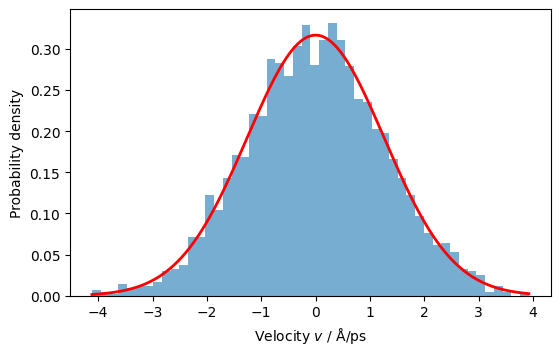

In [15]:
v_flattened = initial_velocities.flatten()

plt.figure(figsize=(latexFigureWidth, latexFigureWidth*6/10))
plt.hist(v_flattened, bins=50, density=True, alpha=0.6, label='Simulation')

x = np.linspace(min(v_flattened), max(v_flattened), 1000)
scale = np.sqrt(k_B * 300 / (mass * u_to_eV))
plt.plot(x, np.exp(-x**2/(2*scale**2))/np.sqrt(2*np.pi*scale**2),
             'r-', linewidth=2, label='Theoretical (Gaussian)')

plt.xlabel(r'Velocity $v$ / $\mathrm{Å/ps}$')
plt.ylabel(r'Probability density')

# plt.savefig("initial_velocity.pdf", format="pdf", dpi=600)

plt.show()

### Actual simulation

Updating the velocity and the position of each atoms according to the extended 5-step verlet integration algorithm:
\begin{align}
p &\rightarrow e^{-\gamma \mathrm{d}t/2} p + \sqrt{m k_B T}\sqrt{1-e^{-\gamma \mathrm{d}t}}\xi_1 \\
p &\rightarrow p - \frac{\partial V}{\partial q} \frac{\mathrm{d}t}{2} \\
q &\rightarrow q + \frac{p}{m} \mathrm{d}t \\
p &\rightarrow p - \frac{\partial V}{\partial q} \frac{\mathrm{d}t}{2} \\
p &\rightarrow e^{-\gamma \mathrm{d}t/2} p + \sqrt{m k_B T}\sqrt{1-e^{-\gamma \mathrm{d}t}}\xi_2
\end{align}
where $\xi$ are small random forces and $\gamma$ are damping coefficients

In [98]:
def run_md_simulation(lattice, velocities, neighbors_map, gamma=0, T=300, dt=0.001, steps=1000, a=σ, Nx=9, Ny=5, Nz=5, thermalization=False):
  """
  Run a molecular dynamics simulation with the Velocity Verlet algorithm.

  Parameters:
    - lattice: Initial positions of atoms (Å)
    - velocities: Initial velocities of atoms (Å/ps)
    - neighbors_map: Dictionary mapping atom indices to neighbor indices
    - gamma: damping constant (1/ps)
    - T: Simulation temperature
    - dt: Time step (ps)
    - steps: Number of simulation steps
    - a: lattice parameter (default σ)
    - Nx, Ny, Nz: Supercell dimensions
    - thermalization: If set to true, a few calculations are skipped to make it faster and the progress is plotted

  Returns:
    - trajectory: Array of shape (steps, num_particles, 3) with positions over time
    - velocities_history: Array of shape (steps, num_particles, 3) with velocities over time
    - energies: Dictionary with energy components over time
  """
  num_particles = len(lattice)
  [ax, ay, az] = a * lattice_parameters
  box_size = np.array([Nx * ax, Ny * ay, Nz * az])

  trajectory = np.zeros((steps, num_particles, 3))
  velocities_history = np.zeros((steps, num_particles, 3))

  energies = {
    'kinetic': np.zeros(steps),
    'potential': np.zeros(steps),
    'total': np.zeros(steps),
    'temperature': np.zeros(steps)
  }

  # Set initial positions and velocities
  positions = lattice.copy()
  trajectory[0] = positions
  velocities_history[0] = velocities

  # Set initial energy
  E_kin = kinetic_energy(velocities)
  E_pot = 0 if thermalization else V(positions, neighbors_map, a=a, Nx=Nx, Ny=Ny, Nz=Nz)
  energies['kinetic'][0] = E_kin
  energies['potential'][0] = E_pot
  energies['total'][0] = E_kin + E_pot
  energies['temperature'][0] = temperature(velocities)

  print(f"Beginning Simulation, T = {energies['temperature'][0]:.1f} K, E_total = {energies['total'][0]:.4f} eV")

  # Calculate initial forces
  forces = F(positions, neighbors_map, a=a, Nx=Nx, Ny=Ny, Nz=Nz)

  N, dim = np.shape(initial_velocities)

  for step in range(1, steps):
    # ====== Velocity Verlet integration ====
    # random normally distributed forces
    xi = np.random.normal(0, 1, (2, N, dim))

    velocities = np.exp(-gamma * dt/2)*velocities + np.sqrt(k_B * T / (mass * u_to_eV)) * np.sqrt(1 - np.exp(-gamma * dt)) * xi[0]

    velocities += forces / (mass * u_to_eV) * dt/2
    positions += velocities * dt

    # Apply periodic boundary conditions to keep particles within the box
    positions = positions % box_size

    forces = F(positions, neighbors_map, a=a, Nx=Nx, Ny=Ny, Nz=Nz)
    velocities += forces / (mass * u_to_eV) * dt/2

    velocities = np.exp(-gamma * dt/2)*velocities + np.sqrt(k_B * T / (mass * u_to_eV)) * np.sqrt(1 - np.exp(-gamma * dt)) * xi[1]


    trajectory[step] = positions
    velocities_history[step] = velocities

    # Calculate energies
    E_kin = kinetic_energy(velocities)
    E_pot = 0 if thermalization else V(positions, neighbors_map, a=a, Nx=Nx, Ny=Ny, Nz=Nz)

    energies['kinetic'][step] = E_kin
    energies['potential'][step] = E_pot
    energies['total'][step] = E_kin + E_pot
    energies['temperature'][step] = temperature(velocities)

    if step % 10 == 0 or step == steps - 1:
      if thermalization:
        clear_output(wait=True)
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5, 2.5), sharex=True)
        ax1.plot(np.arange(step), energies['kinetic'][0:step], color="C0")
        ax2.set_ylabel('Kinetic Energy / eV')

        ax2.plot(np.arange(step), energies['temperature'][0:step], color="C1")
        ax2.set_ylabel('Temperature $T$ / K')

        plt.tight_layout()
        plt.show()
      else:
        print(f"Step {step}/{steps-1}, T = {energies['temperature'][step]:.1f} K, E_total = {energies['total'][step]:.4f} eV")

  return trajectory, velocities_history, energies

In [ ]:
trajectories, velocities_history, energies = run_md_simulation(lattice, initial_velocities, neighbors_map=nearest_neighbors, gamma=100, T=300, steps=200)

### Save and load the thermalized results

Save (and load) the final position and velocity (and energies) for later computation. This is the state after the thermalization

In [17]:
def safe_thermalized_data(filename, positions, velocities):
  thermalized_data = np.hstack((positions, velocities))
  np.savetxt(filename, thermalized_data, delimiter=",", header="x,y,z,vx,vy,vz", comments='')

def load_thermalized_data(filename):
  loaded_data = np.loadtxt(filename, delimiter=",", skiprows=1)
  thermal_positions = loaded_data[:, :3]    # First 3 columns (x, y, z)
  thermal_velocities = loaded_data[:, 3:]   # Last 3 columns (vx, vy, vz)

  return thermal_positions, thermal_velocities

### Visualize the data

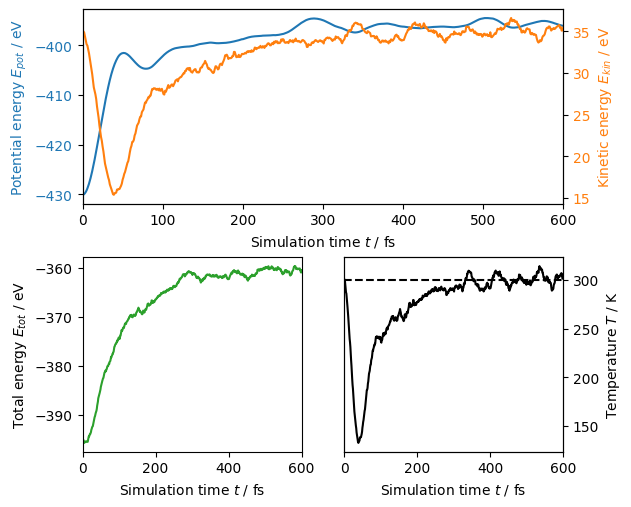

In [ ]:
from matplotlib.gridspec import GridSpec

time = np.arange(0, len(trajectories)) # in fs

fig = plt.figure(layout="constrained", figsize=(latexFigureWidth, latexFigureWidth*8/10))
# fig.tight_layout()

gs = GridSpec(2, 2, figure=fig)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])

# Potential Energy
ax1.plot(time, energies['potential'], color="C0")
ax1.set_ylabel(r"Potential energy $E_{pot}$ / $\mathrm{eV}$", color="C0")
ax1.tick_params(axis='y', labelcolor="C0")

ax1_ = ax1.twinx()
ax1_.plot(time, energies['kinetic'], color="C1")
ax1_.set_ylabel(r"Kinetic energy $E_{kin}$ / $\mathrm{eV}$", color="C1")
ax1_.tick_params(axis='y', labelcolor="C1")

ax1.set_xlim(0, time[-2])
ax1.set_xlabel(r"Simulation time $t$ / $\mathrm{fs}$")


# Total energy
ax2.plot(time, energies['total'], color="C2")
ax2.set_ylabel(r"Total energy $E_{tot}$ / $\mathrm{eV}$")
ax2.set_xlabel(r"Simulation time $t$ / $\mathrm{fs}$")
ax2.set_xlim(0, time[-2])

# Temperature
ax3_ = ax3.twinx()
ax3_.plot(time, energies['temperature'], color="black")
ax3_.hlines(300, 0, 4000, color="black", linestyles="dashed")
ax3_.set_ylabel(r"Temperature $T$ / $\mathrm{K}$")
ax3.set_xlabel(r"Simulation time $t$ / $\mathrm{fs}$")
ax3.set_yticks([])
ax3.set_xlim(0, time[-2])

plt.savefig("thermalization-gamma-0.01.pdf", format="pdf", dpi=600)

plt.show()

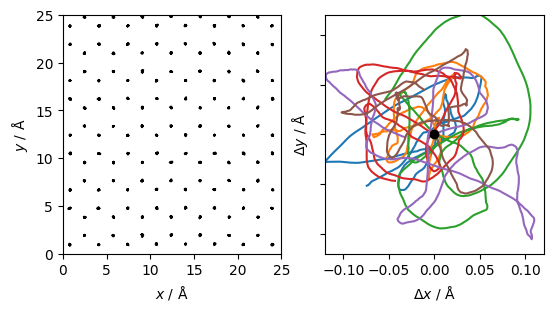

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(latexFigureWidth, latexFigureWidth/2))

# Total lattice
for i in range(900):
  if i % 5 == 0:
    ax1.plot(trajectories[:,i,0], trajectories[:,i,1], color="black")
ax1.set_xlabel(r"$x$ / $\mathrm{Å}$")
ax1.set_ylabel(r"$y$ / $\mathrm{Å}$")
ax1.set_xlim(0, 25)
ax1.set_ylim(0, 25)

# Zoomed 1 Atom
for i in range(6):
    ax2.plot(trajectories[:,i*10,0]-trajectories[0,i*10,0], trajectories[:,i*10,1]-trajectories[0,i*10,1])
ax2.plot(0, 0, "o", color="black")
ax2.set_xlabel(r"$\Delta x$ / $\mathrm{Å}$")
ax2.set_ylabel(r"$\Delta y$ / $\mathrm{Å}$")
ax2.set_xlim(-0.12, 0.12)
ax2.set_ylim(-0.12, 0.12)
ax2.set_xticks([-0.1, -0.05, 0, 0.05, 0.1])
ax2.set_yticklabels([])
ax2.set_yticks([-0.1, -0.05, 0, 0.05, 0.1])

plt.savefig("trajectories.pdf", format="pdf", dpi=600)

plt.show()

## Auto-Correlation

The **position-position** autocorrelation function $C(t)$ is given by
$$
C(t) = \frac{\Delta t}{T - t} \sum_{0 < t' < T-t} \frac{\langle\delta\vec{r}_i(t') \cdot \delta\vec{r}_i(t'+t)\rangle_N }{\langle \delta\vec{r}_i(t') \cdot \delta\vec{r}_i(t')\rangle_N}
$$
where $\langle\dots\rangle_N$ is the mean over all atoms
$$
\langle x_i(t)\rangle_N = \frac{1}{N} \sum^{N}_{i=1} x_i(t)
$$
and $\delta \vec{r}_i(t) = \vec{r}_i(t) - \langle\vec{r}_i\rangle_T$ is the atomic displacement around the equilibrium position. The function is normalized with $C(0)=1$.

In [ ]:
thermal_pos_0_001, thermal_vel_0_001 = load_thermalized_data("thermalized_state_2500fs_gamma_0.001.csv")
thermal_pos_0_01, thermal_vel_0_01 = load_thermalized_data("thermalized_state_1000fs_gamma_0.01.csv")
thermal_pos_0_1, thermal_vel_0_1 = load_thermalized_data("thermalized_state_1000fs_gamma_0.1.csv")

# Molecular dynamics simulation for t=100 fs
traj_0_001, vel_0_001, _ = run_md_simulation(thermal_pos_0_001, thermal_vel_0_001, neighbors_map=nearest_neighbors,
                                             gamma=1, T=300, dt=0.001, steps=1001, thermalization=True)
traj_0_01, vel_0_01, _ = run_md_simulation(thermal_pos_0_01, thermal_vel_0_001, neighbors_map=nearest_neighbors,
                                           gamma=10, T=300, dt=0.001, steps=1001, thermalization=True)
traj_0_1, vel_0_1, _ = run_md_simulation(thermal_pos_0_1, thermal_vel_0_001, neighbors_map=nearest_neighbors,
                                         gamma=100, T=300, dt=0.001, steps=1001, thermalization=True)

In [ ]:
np.savez('0_001.npz', trajectories=traj_0_001, velocities=vel_0_001)
np.savez('0_01.npz', trajectories=traj_0_01, velocities=vel_0_01)
np.savez('0_1.npz', trajectories=traj_0_1, velocities=vel_0_1)

In [54]:
# load in data
data_0_001 = np.load("C:\\Users\\janbu\\Downloads\\0_001.npz")
data_0_01 = np.load("C:\\Users\\janbu\\Downloads\\0_01.npz")
data_0_1 = np.load("C:\\Users\\janbu\\Downloads\\0_1.npz")

traj_0_001, vel_0_001 = data_0_001['trajectories'], data_0_001['velocities']
traj_0_01, vel_0_01 = data_0_01['trajectories'], data_0_01['velocities']
traj_0_1, vel_0_1 = data_0_1['trajectories'], data_0_1['velocities']

In [48]:
def position_auto_correlation(trajectories, dt=0.001):
  """
  Compute the position-position auto-correlation function for the 3D simulated trajectories

  Parameters:
    - trajectories: Atom trajectories in the shape (T, N, 3), where T is the number of total time steps and N is the particles number.
    - dt: Time interval between measurement points (in ps)

  Returns:
    - t: Time steps the auto-correlation function was computed (in ps)
    - C_t: Auto-correlation function to the times t
  """
  T, N, _ = np.shape(trajectories)

  C_t = np.zeros(T)

  # δr_i(t)
  normalized_trajectories = trajectories - np.mean(trajectories, axis=0)  # shape (T, N, 3)

  for t in range(T):

    correlation_sum = 0
    for t_prime in range(T-t):

      r_t_prime = normalized_trajectories[t_prime]    # shape (N, 3)
      r_t_plus_t_prime = normalized_trajectories[t_prime + t] # shape (N, 3)

      # <δr(t') · δr(t+t')>
      numerator_dot_product = np.sum(r_t_plus_t_prime * r_t_prime, axis=1)  # shape (N)
      numerator = np.mean(numerator_dot_product)  # scalar

      # <δr(t') · δr(t')>
      denominator_dot_product = np.sum(r_t_prime * r_t_prime, axis=1)  # shape (N)
      denominator = np.mean(denominator_dot_product)  # scalar

      correlation_sum += numerator / denominator

    # the dt is already included in T, since T is "the number of simulation steps" and not
    # the total time in ps
    C_t[t] = 1 / (T - t) * correlation_sum

  return np.arange(T) * dt, C_t


Calculate the correlation time $\tau$ using the auto-correlation function from previously as
$$
\tau = \int_0^{T} \mathrm{d}t \, C(t)
$$
Because $C(t)$ is discrete here, it is caluclatable by discrete integration (e.g. Bode or Simpson integration algorithm) as
$$
\tau \approx \sum_{i=0}^{T} C(i \cdot \mathrm{d}t) \, \mathrm{d}t
$$

In [67]:
def correlation_time(C_t, dt=0.001, algorithm="bode"):
  """
  Calculates the coherence time from the auto-correlation function

  Parameters:
    - C_t: discrete auto-correlation function
    - dt: time-step (ps)
    - algorithm: Integration algorithm to use. One of "trivial", "trapz", "bode", "simpson"

  Returns:
    - tau: correlation time (ps)
  """
  # only take the values of C_t until the first negative number appears
  crossing_index = np.where(np.diff(np.sign(C_t)))[0][0] + 1
  pacf = C_t[:crossing_index]

  if algorithm == "trivial":
    return np.sum(pacf * dt)

  if algorithm == "trapz":
    integral = 0.0
    for i in range(len(C_t) - 1):
      trapezoid_area = 0.5 * (pacf[i] + pacf[i+1]) * dt
      integral += trapezoid_area
    return integral

  elif algorithm == "bode":
    C = pacf if len(pacf) % 4 == 1 else pacf[0:-((len(pacf) % 4) + 3)]
    integral = 0.0
    for i in range(0, len(C) - 4, 4):
      segment = (7 * C[i] +
                 32 * C[i+1] +
                 12 * C[i+2] +
                 32 * C[i+3] +
                 7 * C[i+4])
      integral += (2 * dt / 45) * segment
    return integral

  elif algorithm == "simpson":
    C = pacf if len(pacf) % 2 == 0 else pacf[0:-(len(pacf) % 2)]
    integral = 0.0
    for i in range(0, len(C) - 2, 2):
      segment = (C[i] + 4 * C[i+1] + C[i+2])
      integral += (dt / 3) * segment
    return integral

  raise ValueError("Unknown algorithm")

In [63]:
time_pacf_0_001, position_acf_0_001 = position_auto_correlation(traj_0_001)
time_pacf_0_01, position_acf_0_01 = position_auto_correlation(traj_0_01)
time_pacf_0_1, position_acf_0_1 = position_auto_correlation(traj_0_1)

In [68]:
tau_0_001 = correlation_time(position_acf_0_001)
tau_0_01 = correlation_time(position_acf_0_01)
tau_0_1 = correlation_time(position_acf_0_1)

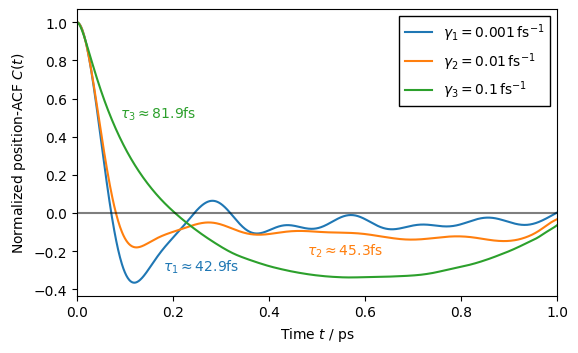

In [ ]:
plt.figure(figsize=(latexFigureWidth, latexFigureWidth*6/10))

plt.plot(time_pacf_0_001, position_acf_0_001, label=r"$\gamma_1=0.001\,\mathrm{fs^{-1}}$")
plt.plot(time_pacf_0_01, position_acf_0_01, label=r"$\gamma_2=0.01\,\mathrm{fs^{-1}}$")
plt.plot(time_pacf_0_1, position_acf_0_1, label=r"$\gamma_3=0.1\,\mathrm{fs^{-1}}$")
plt.hlines(0, 0, 10, color="black", alpha=0.5)

plt.text(0.18, -0.3, f"$\\tau_1\\approx{(tau_0_001*1000):.1f}\\mathrm{{fs}}$", color="C0")
plt.text(0.48, -0.22, f"$\\tau_2\\approx{(tau_0_01*1000):.1f}\\mathrm{{fs}}$", color="C1")
plt.text(0.09, 0.5, f"$\\tau_3\\approx{(tau_0_1*1000):.1f}\\mathrm{{fs}}$", color="C2")

plt.xlabel(r"Time $t$ / $\mathrm{ps}$")
plt.ylabel(r"Normalized position-ACF $C(t)$")
plt.xlim(0, 1)
plt.legend(loc="upper right")

# plt.savefig("position-auto-correlation.pdf", format="pdf", dpi=600)

plt.show()

In [49]:
def velocity_auto_correlation(velocities, dt=0.001):
  """
  Compute a simple version of the velocity auto-correlation function for the 3D simulated trajectories

  Parameters:
    - velocities: Atom velocity histories in the shape (T, N, 3), where T is the number of total time steps and N is the particles number.
    - dt: Time interval between measurement points (in ps)

  Returns:
    - t: Time steps the auto-correlation function was computed (in ps)
    - vacf: Auto-correlation function to the times t
  """
  T, N, _ = velocities.shape
  
  vacf = np.zeros(T)

  v0 = velocities[0]
  norm_factor = np.mean(np.sum(v0 * v0, axis=1))

  for t in range(T):
    vt = velocities[t]   # shape (N, 3)
    vacf[t] = np.mean(np.sum(v0 * vt, axis=1)) / norm_factor
  
  return np.arange(T) * dt, vacf

def vacf_fourier_transform(vacf, dt=0.001):
  T = len(vacf)

  fft_vacf = np.fft.fft(vacf)
  freqs = np.fft.fftfreq(T, d=dt)

  positive_freqs = freqs[:T//2]
  power_spectrum = np.abs(fft_vacf[:T//2])

  return positive_freqs, power_spectrum

In [55]:
time_vacf_0_001, velocity_acf_0_001 = velocity_auto_correlation(vel_0_001)
time_vacf_0_01, velocity_acf_0_01 = velocity_auto_correlation(vel_0_01)
time_vacf_0_1, velocity_acf_0_1 = velocity_auto_correlation(vel_0_1)

freq_vacf_0_001, power_spec_vacf_0_001 = vacf_fourier_transform(velocity_acf_0_001)
freq_vacf_0_01, power_spec_vacf_0_01 = vacf_fourier_transform(velocity_acf_0_01)
freq_vacf_0_1, power_spec_vacf_0_1 = vacf_fourier_transform(velocity_acf_0_1)

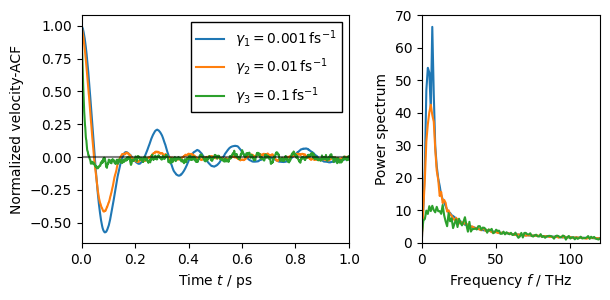

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(latexFigureWidth, latexFigureWidth/2), gridspec_kw={'width_ratios': [3, 2]})

ax1.plot(time_vacf_0_001, velocity_acf_0_001, label=r"$\gamma_1=0.001\,\mathrm{fs^{-1}}$")
ax1.plot(time_vacf_0_01, velocity_acf_0_01, label=r"$\gamma_2=0.01\,\mathrm{fs^{-1}}$")
ax1.plot(time_vacf_0_1, velocity_acf_0_1, label=r"$\gamma_3=0.1\,\mathrm{fs^{-1}}$")
ax1.hlines(0, 0, 10, color="black", alpha=0.5)
ax1.set_xlabel(r"Time $t$ / $\mathrm{ps}$")
ax1.set_ylabel(r"Normalized velocity-ACF")
ax1.set_xlim(0, 1)
ax1.legend(loc="upper right")

ax2.plot(freq_vacf_0_001, power_spec_vacf_0_001)
ax2.plot(freq_vacf_0_01, power_spec_vacf_0_01)
ax2.plot(freq_vacf_0_1, power_spec_vacf_0_1)
ax2.set_xlabel(r"Frequency $f$ / $\mathrm{THz}$")
ax2.set_ylabel(r"Power spectrum")
ax2.set_xlim(0, 120)
ax2.set_ylim(0, 70)

plt.tight_layout()
# plt.savefig("velocity-auto-correlation.pdf", format="pdf", dpi=600)
plt.show()

## Mean-Square-Displacement

The mean-square-displacement (MSD) is calculated by
$$
MSD = \frac{1}{N} \sum_{i=1}^N \frac{1}{T} \sum_{k=0}^T \Delta \vec{r}_i(t_k) \cdot \Delta \vec{r}_i(t_k)
$$
where $\Delta \vec{r}_i(t_k) = \vec{r}_i(t) - \vec{r}_{i\mathrm{,\ eq}}$ is the position displacement from the equilibrium point.
The equilibrium point can be chosen as either $\vec{r}_i(t=0)$ or as $\langle\vec{r}_i\rangle_T$.

In [201]:
def mean_square_displacement(trajectories, dt=0.001, sample_time=0.001, equilibrium_pos="origin"):
  """
  Compute the Meas-Square-Displacement (MSD) for the 3D simulated trajectories

  Parameters:
    - trajectories: Atom trajectories in the shape (T, N, 3), where T is the number of total time steps and N is the particles number.
    - dt: time steps in the trajectories array
    - sample_time: time after how many ps it should be sampled
    - equilibrium_pos: How the equilibrium position is calculated.
        Possible values:  - array with shape (N, 3), (3) or scalar
                          - origin: for using the initial position after thermalization
                          - avg: for using the average position in time

  Returns:
    - msd: mean-square displacement
  """
  T, N, _ = trajectories.shape

  sample_idx = int(sample_time // dt)

  # either take r_eq as the mean of r or as the starting point
  if type(equilibrium_pos) == str:
    if equilibrium_pos == "avg":
      Δr = trajectories[::sample_idx] - np.mean(trajectories, axis=0)
    elif equilibrium_pos == "origin":
      Δr = trajectories[::sample_idx] - trajectories[0,:,:]
    else:
      raise ValueError("Unknown equilibrium position")
  else:
    Δr = trajectories[::sample_idx] - equilibrium_pos


  squared_displacements = np.sum(Δr**2, axis=2) # shape (T, N)

  avg_per_atom = np.mean(squared_displacements, axis=0) # shape (N)

  msd = np.mean(avg_per_atom)

  return msd

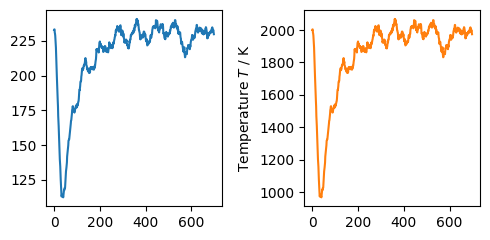

In [ ]:
temperatures = [800, 1400, 1586, 2000]
msd = []

for Temp in temperatures:
  # a gamma of 10 ps^-1  equal to 0.01 fs^-1
  # thermalize for 400 steps, then run for 300 steps
  velocities = maxwell_boltzmann(len(lattice), T=Temp)
  traj_temperature, vel_temperature, _ = run_md_simulation(lattice, velocities, neighbors_map=nearest_neighbors, 
            gamma=10, T=Temp, steps=700, dt=0.001, a=σ, thermalization=True)

  np.savez(f'0_01_T_{Temp}K.npz', trajectories=traj_temperature[400:], velocities=vel_temperature[400:])
  
  # coherence time is (as calculated before) around 45 fs (0.045 ps)
  msd.append(mean_square_displacement(traj_temperature[400:], equilibrium_pos="origin", dt=0.001, sample_time=0.045))

np.savetxt("MSD-temperatures.csv", np.column_stack((temperatures, msd)), delimiter=',', header='T,MSD', comments='')

In [187]:
MSD_data = np.loadtxt("./data/MSD-temperatures.csv", delimiter=',', skiprows=1)
MSD_coefficients = np.polyfit(MSD_data[:5,0], MSD_data[:5,1], 1)

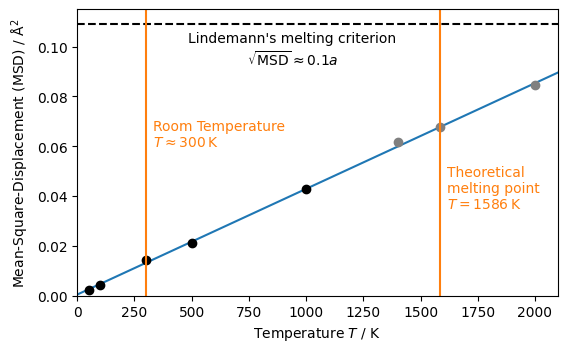

In [188]:
T_continuous = np.linspace(0, 2100)
plt.figure(figsize=(latexFigureWidth, latexFigureWidth*6/10))

plt.plot(T_continuous, MSD_coefficients[0]*T_continuous+MSD_coefficients[1], color="C0")
plt.plot(MSD_data[:5,0], MSD_data[:5,1], "o", color="black")
plt.plot(MSD_data[6:,0], MSD_data[6:,1], "o", color="gray")

plt.hlines((0.1 * σ)**2, 0, 10000, linestyle="--", color="black")
plt.text(940, 0.106, "Lindemann's melting criterion" "\n" r"$\sqrt{\mathrm{MSD}}\approx0.1a$", color="black", ha="center", va="top")

plt.vlines([300, 1586], 0, 10, color="C1")
plt.text(330, 0.06, "Room Temperature" "\n" r"$T\approx300\,\mathrm{K}$", ha="left", color="C1")
plt.text(1615, 0.035, "Theoretical\nmelting point" "\n" r"$T=1586\,\mathrm{K}$", ha="left", color="C1")

plt.xlabel(r"Temperature $T$ / $\mathrm{K}$")
plt.ylabel(r"Mean-Square-Displacement (MSD) / $\mathrm{Å^2}$")

plt.xlim(0, 2100)
plt.ylim(0, 0.115)

# plt.savefig("MSD.pdf", format="PDF", dpi=600)

plt.show()

## Finding equilibrium lattice parameter $a$

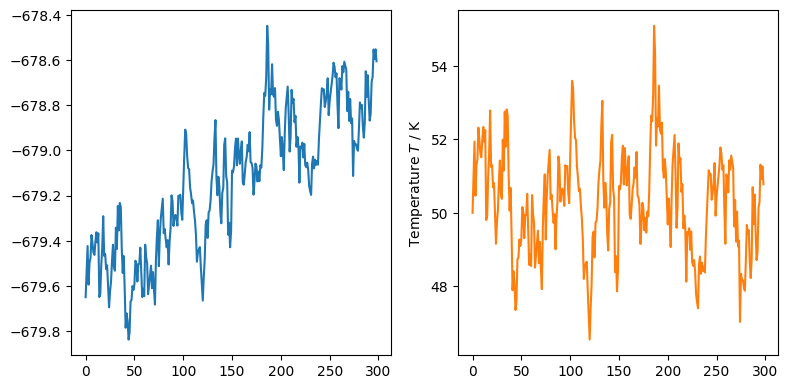

Beginning Simulation, T = 51.6 K, E_total = -678.5093 eV
Step 10/79, T = 49.9 K, E_total = -678.6744 eV
Step 20/79, T = 48.8 K, E_total = -678.7635 eV
Step 30/79, T = 49.4 K, E_total = -678.6683 eV
Step 40/79, T = 47.7 K, E_total = -678.8422 eV
Step 50/79, T = 46.0 K, E_total = -679.0134 eV
Step 60/79, T = 47.1 K, E_total = -678.8594 eV
Step 70/79, T = 49.7 K, E_total = -678.5282 eV
Step 79/79, T = 48.2 K, E_total = -678.6642 eV


In [ ]:
a_values = σ * np.array([0.8, 0.85, 0.9, 0.95, 1.0, 1.05, 1.1, 1.15, 1.2])
steps = np.array([40, 40, 60, 100, 150, 200, 250, 300, 300])  # fine tuned steps until thermilization
temp = 1000

avg_total_energy = np.zeros_like(a_values)
err_total_energy = np.zeros_like(a_values)

for a_idx, a in enumerate(a_values):
  lattice_a = setup_Gd_crystal(a=a)
  nearest_neighbors_a = find_nearest_neighbors(lattice_a, a=a)
  initial_velocities_a = maxwell_boltzmann(len(lattice_a), T=temp)

  # thermalize
  thermalized_position, thermalized_velocity, _ = run_md_simulation(lattice_a, initial_velocities_a, neighbors_map=nearest_neighbors_a, a=a, gamma=100, T=temp, dt=0.001, steps=steps[a_idx], plot=True)

  # production run
  _, _, energies = run_md_simulation(thermalized_position[-1], thermalized_velocity[-1], neighbors_map=nearest_neighbors_a, a=a, gamma=100, T=temp, dt=0.001, steps=80)

  avg_total_energy[a_idx] = np.mean(energies["total"])
  err_total_energy[a_idx] = np.std(energies["total"]) / np.sqrt(len(energies["total"]))

In [ ]:
def save_a_data_to_csv(filename, a, total_energy, error):
  data = np.column_stack((a, total_energy, error))
  headers = ['a', 'total_energy', 'error']
  np.savetxt(filename, data, delimiter=',', header=','.join(headers), comments='')
  print(f"Data successfully saved to {filename}")

def load_a_data(filename):
  data = np.loadtxt(filename, delimiter=',', skiprows=1)
  a = data[:, 0]
  total_energy = data[:, 1]
  error = data[:, 2]

  return a, total_energy, error

In [ ]:
save_a_data_to_csv("equilibrium_1000K_gamma_0_1.csv", a_values, avg_total_energy, err_total_energy)

Data successfully saved to equilibrium_50K_gamma_0_1.csv


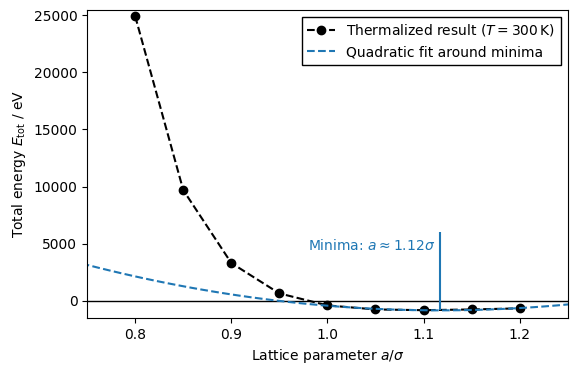

In [ ]:
a_cont = np.linspace(.7, 1.3)
# E_predicted = 5.3* 4*ϵ*900*((1/a_cont)**12 - (1/a_cont)**6) + (3/2 * 900 * k_B * 300)
coefficients = np.polyfit(a_values[4:]/σ, avg_total_energy[4:], 2)
minima = -coefficients[1] / (2 * coefficients[0])

plt.figure(figsize=(6.2, 4))
plt.hlines(0, 0, 10, color="black", linewidth=1)

plt.plot(a_values/σ, avg_total_energy, "o--", color="black", label=r"Thermalized result ($T=300\,\mathrm{K}$)")
# plt.plot(a_cont, E_predicted, label="Predicted")

plt.plot(a_cont, coefficients[0]*a_cont**2 + coefficients[1]*a_cont + coefficients[2], "--", color="C0", label="Quadratic fit around minima")

plt.text(0.98, 4500, f"Minima: $a \\approx {minima:.2f}\\sigma$", color="C0")
plt.vlines(minima, -800, 6000, color="C0")

plt.xlabel(r"Lattice parameter $a/\sigma$")
plt.ylabel(r"Total energy $E_\mathrm{tot}$ / $\mathrm{eV}$")

plt.ylim(-1500, 25500)
plt.xlim(0.75, 1.25)

plt.legend(loc="upper right")

plt.savefig("equilibrium_a_300K.pdf", format="pdf", dpi=600)

plt.show()

In [ ]:
_, E_300, _ = load_a_data("equilibrium_300K_gamma_0_1.csv")
_, E_50, _ = load_a_data("equilibrium_50K_gamma_0_1.csv")

300K: 1.1196809977742945
50K: 1.1176412480167082


(0.95, 1.25)

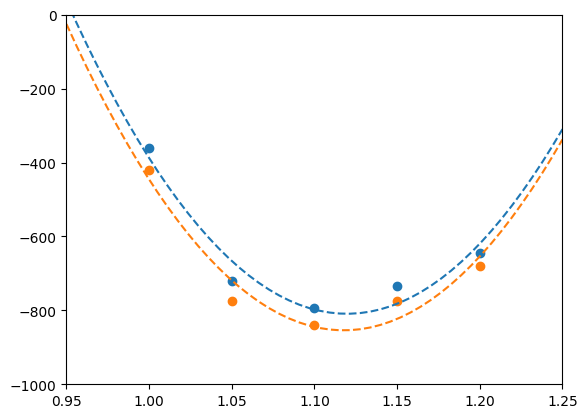

In [ ]:
a_cont = np.linspace(0.95, 1.25)

coefficients_300 = np.polyfit(a_values[4:]/σ, E_300[4:], 2)
coefficients_50 = np.polyfit(a_values[4:]/σ, E_50[4:], 2)

print("300K:", -coefficients_300[1] / (2 * coefficients_300[0]))
print("50K:", -coefficients_50[1] / (2 * coefficients_50[0]))

plt.plot(a_values/σ, E_300, "o")
plt.plot(a_values/σ, E_50, "o")

plt.plot(a_cont, coefficients_300[0]*a_cont**2 + coefficients_300[1]*a_cont + coefficients_300[2], "--", color="C0")
plt.plot(a_cont, coefficients_50[0]*a_cont**2 + coefficients_50[1]*a_cont + coefficients_50[2], "--", color="C1")

plt.ylim(-1000, 0)
plt.xlim(0.95, 1.25)